<a href="https://colab.research.google.com/github/luckyjoy/cross_validate_random_forest_model/blob/main/build_cross_validate_random_forest_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Random Forest Tuning & Cross-Validation**:

### Random Forest Tuning & Cross-Validation

In this exercise, you will learn how to construct and validate a **Random Forest** ensemble model using **scikit-learn** in Python. By the end of this activity, you will understand how to effectively tune a Random Forest model and evaluate its performance.

**Note:** The notebook is split into two parts, each with a corresponding instructional video. You can start with Part 1, or if you're already familiar with the concepts, you can skip to Part 2.

### Topics covered:
- **Importing necessary libraries**: Learn to set up your Python environment for modeling.
- **Encoding categorical features**: Use one-hot encoding (dummy variables) to handle categorical data.
- **Stratified splitting**: Ensure consistent class distribution during the data split.
- **Fitting the model**: Train a Random Forest model with the prepared dataset.
- **Hyperparameter tuning using GridSearchCV**: Optimize the model by tuning key parameters:
  - `max_depth`
  - `max_features`
  - `min_samples_split`
  - `n_estimators`
  - `min_samples_leaf`
- **Model evaluation**: Evaluate the model’s performance using metrics like **precision**, **recall**, and **F1 score**.

### Learning Goals:
- Understand the importance of hyperparameter tuning in Random Forest models.
- Apply **GridSearchCV** for automatic hyperparameter tuning and cross-validation.
- Evaluate model performance using multiple metrics to ensure the best model is chosen.


All the information you need for solving this assignment is in this notebook, and all the code you will be implementing will take place within this notebook.

## Review

This notebook is a continuation of the bank churn project. Below is a recap of the considerations and decisions that we've already made. For detailed discussion of these topics, refer back to the [fully annotated notebook for the decision tree model](https://www.coursera.org/learn/the-nuts-and-bolts-of-machine-learning/ungradedLab/HVyMU/annotated-follow-along-guide-build-a-decision-tree).

>  **Modeling objective:** To predict whether a customer will churn&mdash;a binary classification task.


>  **Target variable:** `Exited` column&mdash;0 or 1.  

>  **Class balance:** The data is imbalanced 80/20 (not churned/churned), but we will not perform class balancing.

>  **Primary evaluation metric:** F1 score.

>  **Modeling workflow and model selection:** The champion model will be the model with the best validation F1 score. Only the champion model will be used to predict on the test data. See the annotated decision tree notebook for details and limitations of this approach.

## A note on cross-validation/validation

This notebook is for teaching purposes. As such, it includes two approaches to validation: cross-validating the training data and validating using a separate validation dataset. In practice, you generally will only use one or the other for a given project.

Cross-validation is more rigorous, because it maximizes the usage of the training data, but if you have a very large dataset or limited computing resources, it may be better to validate with a separate validation dataset.

## Import statements

Before we begin with the exercises and analyzing the data, we need to import all libraries and extensions required for this programming exercise. Throughout the course, we will be using numpy and pandas for operations, and matplotlib for plotting.

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier

# This module lets us save our models once we fit them.
import pickle

from IPython.display import SVG

## Read in the data

In [ ]:
# Read in data
file = 'Churn_Modelling.csv'
df_original = pd.read_csv(file)
df_original.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Feature engineering

### Feature selection

In this step, we'll prepare the data for modeling.  Notice from above that there are a number of columns that we wouldn't expect to offer any predictive signal to the model. These columns include `RowNumber`, `CustomerID`, and `Surname`. We'll drop these columns so they don't introduce noise to our model.  

We'll also drop the `Gender` column, because we don't want our model to make predictions based on gender.

In [ ]:
# Drop useless and sensitive (Gender) cols
churn_df = df_original.drop(['RowNumber', 'CustomerId', 'Surname', 'Gender'], axis=1)
churn_df.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,41,1,83807.86,1,0,1,112542.58,0
2,502,France,42,8,159660.80,3,1,0,113931.57,1
3,699,France,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,43,2,125510.82,1,1,1,79084.10,0


### Feature transformation

Next, we'll dummy encode the `Geography` variable, which is categorical. We do this with the `pd.get_dummies()` function and setting `drop_first='True'`, which replaces the `Geography` column with two new Boolean columns called `Geography_Germany` and `Geography_Spain`.

In [ ]:
# Dummy encode categoricals
churn_df2 = pd.get_dummies(churn_df, drop_first='True')
churn_df2.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1


## Split the data

We'll split the data into features and target variable, and into training data and test data using the `train_test_split()` function.

Don't forget to include the `stratify=y` parameter, as this is what ensures that the 80/20 class ratio of the target variable is maintained in both the training and test datasets after splitting.

Lastly, we set a random seed so we and others can reproduce our work.

In [ ]:
# Define the y (target) variable
y = churn_df2["Exited"]

# Define the X (predictor) variables
X = churn_df2.copy()
X = X.drop("Exited", axis = 1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

## Modeling

### Cross-validated hyperparameter tuning

The cross-validation process is the same as it was for the decision tree model. The only difference is that we're tuning more hyperparameters now. The steps are included below as a review.

For details on cross-validating with `GridSearchCV`, refer back to the decision tree notebook, or to the [GridSearchCV documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) in scikit-learn.

1. Instantiate the classifier (and set the `random_state`).

2. Create a dictionary of hyperparameters to search over.

3. Create a set of scoring metrics to capture.

4. Instantiate the `GridSearchCV` object. Pass as arguments:
  - The classifier (`rf`)
  - The dictionary of hyperparameters to search over (`cv_params`)
  - The set of scoring metrics (`scoring`)
  - The number of cross-validation folds you want (`cv=5`)
  - The scoring metric that you want GridSearch to use when it selects the "best" model (i.e., the model that performs best on average over all validation folds) (`refit='f1'`)

5. Fit the data (`X_train`, `y_train`) to the `GridSearchCV` object (`rf_cv`).

Note that we use the `%%time` magic at the top of the cell. This outputs the final runtime of the cell. (Magic commands, often just called "magics," are commands that are built into IPython to simplify common tasks. They begin with `%` or `%%`.)


In [ ]:
%%time

rf = RandomForestClassifier(random_state=0)

cv_params = {'max_depth': [2,3,4,5, None],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'max_features': [2,3,4],
             'n_estimators': [75, 100, 125, 150]
             }

scoring = {'accuracy', 'precision', 'recall', 'f1'}

rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='f1')

# rf_cv.fit(X_train, y_train)

CPU times: user 44 µs, sys: 22 µs, total: 66 µs
Wall time: 70.3 µs


This is the end of the first video. The next video will continue from this point.

<a name="part_2"></a>
# Random forest validation on separate dataset

This is a continuation of the bank churn cross-validated random forest modeling notebook. This section of the notebook will demonstrate how to construct and validate a random forest ensemble model in Python with scikit-learn.


Topics of focus include:

  * Using `pickle` to save a fit model
  * Using a separate dataset to tune hyperparameters and validate your model
    * Splitting the training data to create a validation dataset
    * Creating a list of split indices to use with `PredefinedSplit` so `GridSearchCV` performs validation on this defined validation set

## Pickle  

When models take a long time to fit, you don’t want to have to fit them more than once. If your kernel disconnects or you shut down the notebook and lose the cell’s output, you’ll have to refit the model, which can be frustrating and time-consuming.

`pickle` is a tool that saves the fit model object to a specified location, then quickly reads it back in. It also allows you to use models that were fit somewhere else, without having to train them yourself.

In [ ]:
# Define a path to the folder where you want to save the model
path = '/home/jovyan/work/'

This step will ***W***rite (i.e., save) the model, in ***B***inary (hence, `wb`), to the folder designated by the above path. In this case, the name of the file we're writing is `rf_cv_model.pickle`.

In [ ]:
# Pickle the model
with open(path+'rf_cv_model.pickle', 'wb') as to_write:
    pickle.dump(rf_cv, to_write)

Once we save the model, we'll never have to re-fit it when we run this notebook. Ideally, we could open the notebook, select "Run all," and the cells would run successfully all the way to the end without any model retraining.

For this to happen, we'll need to return to the cell where we defined our grid search and comment out the line where we fit the model. Otherwise, when we re-run the notebook, it would refit the model.

Similarly, we'll also need to go back to where we saved the model as a pickle and comment out those lines.  

Next, we'll add a new cell that reads in the saved model from the folder we already specified. For this, we'll use `rb` (read binary) and be sure to assign the model to the same variable name as we used above, `rf_cv`.

In [ ]:
# Read in pickled model
with open(path + 'rf_cv_model.pickle', 'rb') as to_read:
    rf_cv = pickle.load(to_read)

Now everything above is ready to run quickly and without refitting. We can continue by using the model's `best_params_` attribute to check the hyperparameters that had the best average F1 score across all the cross-validation folds.

In [ ]:
rf_cv.fit(X_train, y_train)
rf_cv.best_params_

{'max_depth': None,
 'max_features': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 125}

And to check the best average F1 score of this model on the validation folds, we can use the `best_score_` attribute. Remember, if we had instead set `refit=recall` when we instantiated our `GridSearchCV` object earlier, then calling `best_score_` would return the best recall score, and the best parameters might not be the same as what they are in the above cell, because the model would be optimizing for a different metric.

In [ ]:
rf_cv.best_score_

0.580528563620339

Our model had an F1 score of 0.5805&mdash;not terrible. Recall that when we ran our grid search, we specified that we also wanted to capture precision, recall, and accuracy.

The reason for doing this is that it's difficult to interpret an F1 score. These other metrics are much more directly interpretable, so they're worth knowing.

The following cell defines a helper function that extracts these scores from the fit `GridSearchCV` object and returns a pandas dataframe with all four scores from the model with the best average F1 score during validation.

In [ ]:
def make_results(model_name, model_object):
    '''
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean F1 score across all validation folds.
    '''

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'Model': [model_name],
                          'F1': [f1],
                          'Recall': [recall],
                          'Precision': [precision],
                          'Accuracy': [accuracy]
                         }
                        )

    return table

In [ ]:
# Make a results table for the rf_cv model using above function
rf_cv_results = make_results('Random Forest CV', rf_cv)
rf_cv_results

,Model,F1,Recall,Precision,Accuracy
0,Random Forest CV,0.580529,0.472517,0.756289,0.861333


We can concatenate these results to our master results table from when we built the single decision tree model.

In [ ]:
# Read in master results table
results = pd.read_csv('results1.csv', index_col=0)
results

,Model,F1,Recall,Precision,Accuracy
0,Tuned Decision Tree,0.560655,0.469255,0.701608,0.8504


In [ ]:
# Concatenate the random forest results to the master table
results = pd.concat([rf_cv_results, results])
results

,Model,F1,Recall,Precision,Accuracy
0,Random Forest CV,0.580529,0.472517,0.756289,0.861333
0,Tuned Decision Tree,0.560655,0.469255,0.701608,0.850400


The scores in the above table tell us that the random forest model performs better than the single decision tree model on every metric. Nice!

Now, let's build another random forest model, only this time we'll tune the hyperparameters using a separate validation dataset.



## Modeling

### Hyperparameters tuned with separate validation set  

Begin by splitting the training data to create a validation dataset. Remember, we won't touch the test data at all.  

We'll use `train_test_split` to divide `X_train` and `y_train` into 80% training data (`X_tr`, `y_tr`) and 20% validation data (`X_val`, `y_val`). Don't forget to stratify it and set the random state.

In [ ]:
# Create separate validation data
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2,
                                            stratify=y_train, random_state=10)

When we tune hyperparameters with `GridSearchCV` using a separate validation dataset, we have to take a few extra steps. `GridSearchCV` wants to cross-validate the data. In fact, if the `cv` argument were left blank, it would split the data into five folds for cross-validation by default.

We don't want it to do this. Instead, we're going to tell it exactly which rows of `X_train` are for training, and which rows are for validation.  

To do this, we need to make a list of length `len(X_train)` where each element is either a 0 or -1. A 0 in index _i_ will indicate to `GridSearchCV` that index _i_ of `X_train` is to be held out for validation. A -1 at a given index will indicate that that index of `X_train` is to be used as training data.

We'll make this list using a list comprehension that looks at the index number of each row in `X_train`. If that index number is in `X_val`'s list of index numbers, then the list comprehension appends a 0. If it's not, then it appends a -1.

So if our training data is:  
[A, B, C, D],  
and our list is:   
[-1, 0, 0, -1],  
then `GridSearchCV` will use a training set of [A, D] and validation set of [B, C].

In [ ]:
# Create list of split indices
split_index = [0 if x in X_val.index else -1 for x in X_train.index]

Now that we have this list, we need to import a new function called `PredefinedSplit`. This function is what allows us to pass the list we just made to `GridSearchCV`. (You can read more about this function in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.PredefinedSplit.html#sklearn.model_selection.PredefinedSplit).)

In [ ]:
from sklearn.model_selection import PredefinedSplit

Now we can build the model. Everything is the same as when we cross-validated, except this time we pass the `split_index` list to the `PredefinedSplit` function and assign it to a new variable called `custom_split`.

Then we'll use this variable for the `cv` argument when we instantiate `GridSearchCV`.

In [ ]:
rf = RandomForestClassifier(random_state=0)

cv_params = {'max_depth': [2,3,4,5, None],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'max_features': [2,3,4],
             'n_estimators': [75, 100, 125, 150]
             }

scoring = {'accuracy', 'precision', 'recall', 'f1'}

custom_split = PredefinedSplit(split_index)

rf_val = GridSearchCV(rf, cv_params, scoring=scoring, cv=custom_split, refit='f1')

Now fit the model.

In [ ]:
rf_val.fit(X_train, y_train)

CPU times: user 3min 51s, sys: 1.2 s, total: 3min 53s
Wall time: 3min 53s


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1,  0, ..., -1, -1])),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weigh...
                                              oob_score=False, random_state=0,
                                              verbose=0, warm_

Notice that this took less time than when we cross-validated—about 1/5 of the time. This is because during cross-validation the training data was divided into five folds. An ensemble of trees was grown with a particular combination of hyperparameters on four folds of data, and validated on the fifth fold that was held out. This whole process happened for each of five holdout folds. Then, another ensemble was trained with the next combination of hyperparameters, repeating the whole process. This continued until there were no more combinations of hyperparameters to run.

Saving cross_validation_diagram.svg to cross_validation_diagram (2).svg


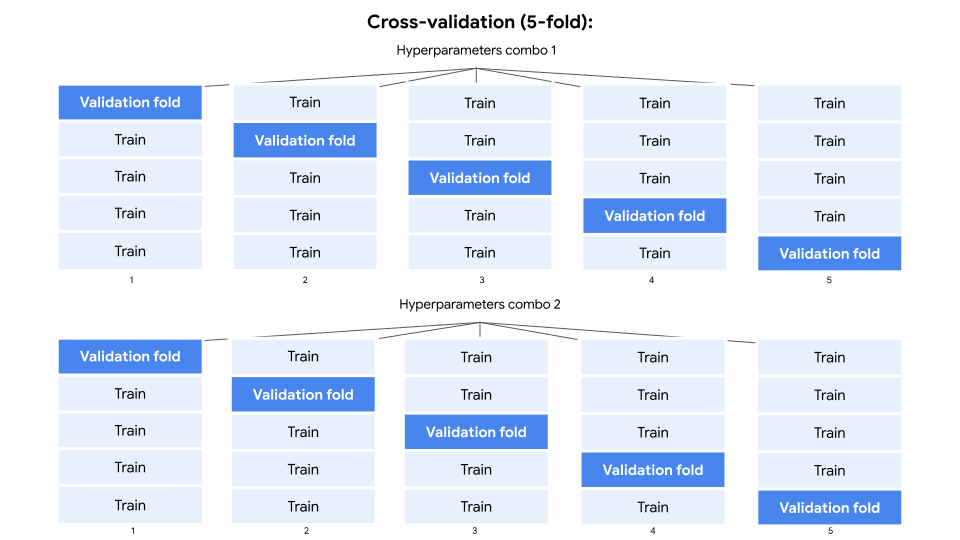

In [6]:
uploaded = files.upload()
# Display the SVG file
SVG('cross_validation_diagram.svg')

But now that we're _using a separate validation set,_ an ensemble is built for each combination of hyperparameters. Each ensemble is trained on the new training set and validated on the validation set. But this only happens _one time_ for each combination of hyperparameters, instead of _five times_ with cross-validation. That’s why the training time was only a fifth as long.

Saving single_validation_diagram.svg to single_validation_diagram.svg


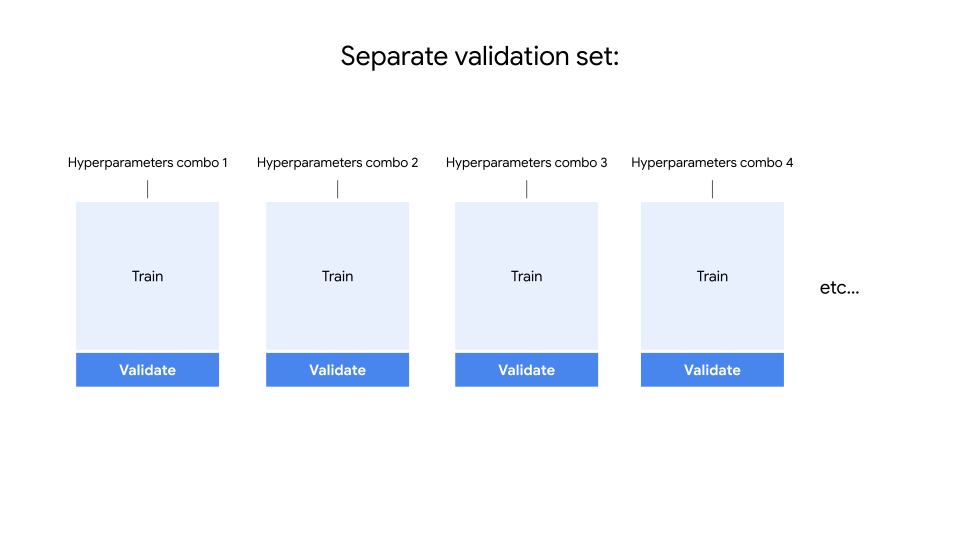

In [7]:
uploaded = files.upload()
# Display the SVG file
SVG('single_validation_diagram.svg')

In [ ]:
# Pickle the model
with open(path+'rf_val_model.pickle', 'wb') as to_write:
    pickle.dump(rf_val, to_write)

... and comment out where we fit the model and wrote the pickle, then read back in the pickled model.

In [ ]:
# Open pickled model
with open(path+'rf_val_model.pickle', 'rb') as to_read:
    rf_val = pickle.load(to_read)

Now check the parameters of the best-performing model on the validation set:

In [ ]:
rf_val.best_params_

{'max_depth': None,
 'max_features': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 150}

Notice that the best hyperparameters were slightly different than the cross-validated model.  

Now, we'll generate the model results using the `make_results` function, add them to the master table, and then sort them by F1 score in descending order.

In [ ]:
# Create model results table
rf_val_results = make_results('Random Forest Validated', rf_val)

# Concatentate model results table with master results table
results = pd.concat([rf_val_results, results])

# Sort master results by F1 score in descending order
results.sort_values(by=['F1'], ascending=False)

,Model,F1,Recall,Precision,Accuracy
0,Random Forest CV,0.580529,0.472517,0.756289,0.861333
0,Random Forest Validated,0.575510,0.460784,0.766304,0.861333
0,Tuned Decision Tree,0.560655,0.469255,0.701608,0.850400


We can save the new master table to use later when we build more models.

In [ ]:
# Save the master results table
results.to_csv(path+'results2.csv', index=False);

## Model selection and final results

Now we have three models. If we've decided that we're done trying to optimize them, then we can now use our best model to predict on the test holdout data. We'll be using the cross-validated model without the depth limitation, but if we were instead to use the model that was validated against a separate validation dataset, we'd now go back and retrain the model on the full training set (training + validation sets).

**Note**: _It might be tempting to see how all models perform on the test holdout data, and then to choose the one that performs best. While this **can** be done, it biases the final model, because you used your test data to go back and make an upstream decision. The test data should represent **unseen** data. In competitions, for example, you must submit your final model before receiving the test data._

The results in the table above tell us that the cross-validated random forest model performs a little better than the one trained on a separate validation set.

It performs well for precision and accuracy, but the recall is 0.4725. This means that out of all the people in the validation folds who _actually_ left the bank, the model successfully identifies 47% of them.

We will not apply the model to the test data yet, because there is still one more model to build. You'll learn about this soon. Once we train that model, we'll use our champion model to predict on the test data.